In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler #scaling de los datos entre 0 y 1
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from os import listdir
from os.path import isfile, join
plt.style.use('seaborn')
plt.style.use('matplotlibrc.py')

Using TensorFlow backend.


In [2]:
  dic_localidades = {
        'RiesgoBariloche':'Bariloche',
        'RiesgoBuenosAires':'Buenos Aires',
        'RiesgoCABACABANA':'CABA',
        'RiesgoChacoNA':'Chaco',
        'RiesgoCórdobaCórdoba':'Córdoba',
        'RiesgoEntreRiosRíos':'Entre Ríos',
        'RiesgoJujuyJujuy':'Jujuy',
        'RiesgoLaRiojaRioja':'La Rioja',
        'RiesgoMendozaMendoza':'Mendoza',
        'RiesgoNeuquénNeuquén':'Neuquén',
        'RiesgoRioNegro':'Río Negro',
        'RiesgoSaltaSalta':'Salta',
        'RiesgoSantaCruzSantaCruz':'Santa Cruz',
        'RiesgoSantaFeSantaFe':'Santa Fe',
        'RiesgoTierradelFuegoTierradel':'Tierra del Fuego',
        'RiesgoTucumanTucuman':'Tucumán'
    }

In [3]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def graph_predictions(l,df_original,y_train_pr,y_test_pr,name):
    plt.plot(df_original) 
    months_tr = np.arange(l,len(y_train_pr)+l) #meses de training
    months_ts = np.arange(len(y_train_pr)+(2*l)+1,len(df_original)-1) #meses de testing
    plt.plot(months_tr,y_train_pr,label='train') #grafico de train results
    plt.plot(months_ts,y_test_pr,label='test') #grafico de test results
    plt.title(dic_localidades[str(name)])
    plt.xlabel('Días')
    plt.ylabel('Casos/100 mil hab')
    plt.legend(fontsize=12)
    plt.savefig(dic_localidades[str(name)]+'_fit_2.pdf')
    plt.show()

In [6]:
seed = 7
np.random.seed(seed)

In [7]:
mypath = 'Datos'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))] #get all file names of that path
df_train_total = [] #aca guardamos todos los datos

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
tw = 3

# armo scaler para los datos

In [9]:
for file in files:
    print(file)
    data = pd.read_csv(mypath+str('/')+file,sep=",",quotechar='"',na_values=[''])
    data = data["incidenciaAcum14d"]
    df = pd.DataFrame(data)
    df = df.to_numpy()
    df = df[:-20]
    total_size = df.shape[0]
    train_size = int(0.8*total_size)
    test_size = total_size - train_size
    train_data = df[:-test_size]
    df_train_total.extend(list(train_data.flatten()))

RiesgoBariloche
RiesgoBuenosAires
RiesgoCABACABANA
RiesgoChacoNA
RiesgoCórdobaCórdoba
RiesgoEntreRiosRíos
RiesgoJujuyJujuy
RiesgoLaRiojaRioja
RiesgoMendozaMendoza
RiesgoNeuquénNeuquén
RiesgoRioNegro
RiesgoSaltaSalta
RiesgoSantaCruzSantaCruz
RiesgoSantaFeSantaFe
RiesgoTierradelFuegoTierradel
RiesgoTucumanTucuman


In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_total = scaler.fit_transform(np.array(df_train_total).reshape(-1,1))

# ahora armo los datos de train, test y forecast

In [11]:
df_forecast = [] #aca van a estar los datos para hacer el forecasting

In [12]:
for file in files:
    print(file)
    data = pd.read_csv(mypath+str('/')+file,sep=",",quotechar='"',na_values=[''])
    data = data["incidenciaAcum14d"]
    df = pd.DataFrame(data)
    df = df.to_numpy()
    df_forecast.append(df[-20:-10])
    df = df[:-20]
    total_size = df.shape[0]
    train_size = int(0.8*total_size)
    test_size = total_size - train_size
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    train_data = scaler.transform(train_data.reshape(-1,1))
    test_data = scaler.transform(test_data.reshape(-1,1))
    if file == 'RiesgoBariloche':
        x_train_total, y_train_total = create_dataset(train_data,tw)
        x_test_total, y_test_total = create_dataset(test_data,tw)
    else:
        #train
        x_train, y_train = create_dataset(train_data,tw)
        x_train_total = np.vstack((x_train_total,x_train))
        y_train_total = np.hstack((y_train_total,y_train))
        #test
        x_test, y_test = create_dataset(test_data,tw)
        x_test_total = np.vstack((x_test_total,x_test))
        y_test_total = np.hstack((y_test_total,y_test))
            

RiesgoBariloche
RiesgoBuenosAires
RiesgoCABACABANA
RiesgoChacoNA
RiesgoCórdobaCórdoba
RiesgoEntreRiosRíos
RiesgoJujuyJujuy
RiesgoLaRiojaRioja
RiesgoMendozaMendoza
RiesgoNeuquénNeuquén
RiesgoRioNegro
RiesgoSaltaSalta
RiesgoSantaCruzSantaCruz
RiesgoSantaFeSantaFe
RiesgoTierradelFuegoTierradel
RiesgoTucumanTucuman


In [13]:
x_train_total = x_train_total.reshape(x_train_total.shape[0],1,x_train_total.shape[1])
x_test_total = x_test_total.reshape(x_test_total.shape[0],1,x_test_total.shape[1])

In [14]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=128,activation='relu',return_sequences=True,input_shape=(1,tw)))
model.add(keras.layers.LSTM(units=128,activation='relu'))
model.add(keras.layers.Dense(units=1))
model.compile(optimizer='adam',loss=keras.losses.MSE,metrics=['mse']) 
model.summary()
history = model.fit(x_train_total, y_train_total,epochs=1000,batch_size=256,validation_data=(x_test_total,y_test_total),verbose=2) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 128)            67584     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 199,297
Trainable params: 199,297
Non-trainable params: 0
_________________________________________________________________
Train on 3478 samples, validate on 830 samples
Epoch 1/1000
 - 1s - loss: 0.0458 - mse: 0.0458 - val_loss: 0.8971 - val_mse: 0.8971
Epoch 2/1000
 - 0s - loss: 0.0362 - mse: 0.0362 - val_loss: 0.6638 - val_mse: 0.6638
Epoch 3/1000
 - 0s - loss: 0.0259 - mse: 0.0259 - val_loss: 0.2702 - val_mse: 0.2702
Epoch 4/1000
 - 0s - loss: 0.0124 - mse: 0.0124 - val_loss: 0.1388 - val_mse

Epoch 81/1000
 - 0s - loss: 6.5349e-05 - mse: 6.5349e-05 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 82/1000
 - 0s - loss: 6.1980e-05 - mse: 6.1980e-05 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 83/1000
 - 0s - loss: 5.9803e-05 - mse: 5.9803e-05 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 84/1000
 - 0s - loss: 5.8952e-05 - mse: 5.8952e-05 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 85/1000
 - 0s - loss: 6.0862e-05 - mse: 6.0862e-05 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 86/1000
 - 0s - loss: 5.5933e-05 - mse: 5.5933e-05 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 87/1000
 - 0s - loss: 5.0525e-05 - mse: 5.0525e-05 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 88/1000
 - 0s - loss: 4.8085e-05 - mse: 4.8085e-05 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 89/1000
 - 0s - loss: 4.6617e-05 - mse: 4.6617e-05 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 90/1000
 - 0s - loss: 5.1212e-05 - mse: 5.1212e-05 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 91/1000
 - 0s - loss: 4.3401e-05 - mse: 4.3401e-05 - v

Epoch 168/1000
 - 0s - loss: 1.4600e-05 - mse: 1.4600e-05 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 169/1000
 - 0s - loss: 1.3622e-05 - mse: 1.3622e-05 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 170/1000
 - 0s - loss: 1.3367e-05 - mse: 1.3367e-05 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 171/1000
 - 0s - loss: 1.3659e-05 - mse: 1.3659e-05 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 172/1000
 - 0s - loss: 1.3381e-05 - mse: 1.3381e-05 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 173/1000
 - 0s - loss: 1.3888e-05 - mse: 1.3888e-05 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 174/1000
 - 0s - loss: 1.3663e-05 - mse: 1.3663e-05 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 175/1000
 - 0s - loss: 1.3736e-05 - mse: 1.3736e-05 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 176/1000
 - 0s - loss: 1.4304e-05 - mse: 1.4304e-05 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 177/1000
 - 0s - loss: 1.4200e-05 - mse: 1.4200e-05 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 178/1000
 - 0s - loss: 1.6545e-05 - mse: 1.6

Epoch 255/1000
 - 0s - loss: 1.3127e-05 - mse: 1.3127e-05 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 256/1000
 - 0s - loss: 1.4932e-05 - mse: 1.4932e-05 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 257/1000
 - 0s - loss: 1.4438e-05 - mse: 1.4438e-05 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 258/1000
 - 0s - loss: 1.4612e-05 - mse: 1.4612e-05 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 259/1000
 - 0s - loss: 1.4175e-05 - mse: 1.4175e-05 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 260/1000
 - 0s - loss: 1.3322e-05 - mse: 1.3322e-05 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 261/1000
 - 0s - loss: 1.5433e-05 - mse: 1.5433e-05 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 262/1000
 - 0s - loss: 1.3035e-05 - mse: 1.3035e-05 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 263/1000
 - 0s - loss: 1.2927e-05 - mse: 1.2927e-05 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 264/1000
 - 0s - loss: 1.4091e-05 - mse: 1.4091e-05 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 265/1000
 - 0s - loss: 1.4107e-05 - mse: 1.4

Epoch 342/1000
 - 0s - loss: 1.3004e-05 - mse: 1.3004e-05 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 343/1000
 - 0s - loss: 1.3703e-05 - mse: 1.3703e-05 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 344/1000
 - 0s - loss: 1.2052e-05 - mse: 1.2052e-05 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 345/1000
 - 0s - loss: 1.2823e-05 - mse: 1.2823e-05 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 346/1000
 - 0s - loss: 1.1912e-05 - mse: 1.1912e-05 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 347/1000
 - 0s - loss: 1.2142e-05 - mse: 1.2142e-05 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 348/1000
 - 0s - loss: 1.5491e-05 - mse: 1.5491e-05 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 349/1000
 - 0s - loss: 1.4440e-05 - mse: 1.4440e-05 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 350/1000
 - 0s - loss: 1.2238e-05 - mse: 1.2238e-05 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 351/1000
 - 0s - loss: 1.1875e-05 - mse: 1.1875e-05 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 352/1000
 - 0s - loss: 1.3171e-05 - mse: 1.3

Epoch 429/1000
 - 0s - loss: 1.2705e-05 - mse: 1.2705e-05 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 430/1000
 - 0s - loss: 1.6256e-05 - mse: 1.6256e-05 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 431/1000
 - 0s - loss: 1.3943e-05 - mse: 1.3943e-05 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 432/1000
 - 0s - loss: 1.2420e-05 - mse: 1.2420e-05 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 433/1000
 - 0s - loss: 1.4156e-05 - mse: 1.4156e-05 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 434/1000
 - 0s - loss: 1.3175e-05 - mse: 1.3175e-05 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 435/1000
 - 0s - loss: 1.2383e-05 - mse: 1.2383e-05 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 436/1000
 - 0s - loss: 1.2259e-05 - mse: 1.2259e-05 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 437/1000
 - 0s - loss: 1.5179e-05 - mse: 1.5179e-05 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 438/1000
 - 0s - loss: 1.6942e-05 - mse: 1.6942e-05 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 439/1000
 - 0s - loss: 1.3387e-05 - mse: 1.3

Epoch 516/1000
 - 0s - loss: 1.2408e-05 - mse: 1.2408e-05 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 517/1000
 - 0s - loss: 1.1734e-05 - mse: 1.1734e-05 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 518/1000
 - 0s - loss: 1.3695e-05 - mse: 1.3695e-05 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 519/1000
 - 0s - loss: 1.2482e-05 - mse: 1.2482e-05 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 520/1000
 - 0s - loss: 1.1894e-05 - mse: 1.1894e-05 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 521/1000
 - 0s - loss: 1.1423e-05 - mse: 1.1423e-05 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 522/1000
 - 0s - loss: 1.2332e-05 - mse: 1.2332e-05 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 523/1000
 - 0s - loss: 1.2593e-05 - mse: 1.2593e-05 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 524/1000
 - 0s - loss: 1.1599e-05 - mse: 1.1599e-05 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 525/1000
 - 0s - loss: 1.2468e-05 - mse: 1.2468e-05 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 526/1000
 - 0s - loss: 1.3769e-05 - mse: 1.3

Epoch 603/1000
 - 0s - loss: 1.2243e-05 - mse: 1.2243e-05 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 604/1000
 - 0s - loss: 1.2605e-05 - mse: 1.2605e-05 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 605/1000
 - 0s - loss: 1.1814e-05 - mse: 1.1814e-05 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 606/1000
 - 0s - loss: 1.3199e-05 - mse: 1.3199e-05 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 607/1000
 - 0s - loss: 1.2588e-05 - mse: 1.2588e-05 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 608/1000
 - 0s - loss: 1.2510e-05 - mse: 1.2510e-05 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 609/1000
 - 0s - loss: 1.1993e-05 - mse: 1.1993e-05 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 610/1000
 - 0s - loss: 1.4757e-05 - mse: 1.4757e-05 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 611/1000
 - 0s - loss: 1.3476e-05 - mse: 1.3476e-05 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 612/1000
 - 0s - loss: 1.3099e-05 - mse: 1.3099e-05 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 613/1000
 - 0s - loss: 1.2008e-05 - mse: 1.2

Epoch 690/1000
 - 0s - loss: 1.1678e-05 - mse: 1.1678e-05 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 691/1000
 - 0s - loss: 1.2366e-05 - mse: 1.2366e-05 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 692/1000
 - 0s - loss: 1.5053e-05 - mse: 1.5053e-05 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 693/1000
 - 0s - loss: 1.1703e-05 - mse: 1.1703e-05 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 694/1000
 - 0s - loss: 1.2029e-05 - mse: 1.2029e-05 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 695/1000
 - 0s - loss: 1.4175e-05 - mse: 1.4176e-05 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 696/1000
 - 0s - loss: 1.4247e-05 - mse: 1.4247e-05 - val_loss: 9.9663e-04 - val_mse: 9.9663e-04
Epoch 697/1000
 - 0s - loss: 1.2113e-05 - mse: 1.2113e-05 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 698/1000
 - 0s - loss: 1.2668e-05 - mse: 1.2668e-05 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 699/1000
 - 0s - loss: 1.2234e-05 - mse: 1.2234e-05 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 700/1000
 - 0s - loss: 1.3589e-05 - 

Epoch 773/1000
 - 0s - loss: 1.1069e-05 - mse: 1.1069e-05 - val_loss: 8.4134e-04 - val_mse: 8.4134e-04
Epoch 774/1000
 - 0s - loss: 1.1630e-05 - mse: 1.1630e-05 - val_loss: 7.3921e-04 - val_mse: 7.3921e-04
Epoch 775/1000
 - 0s - loss: 1.1337e-05 - mse: 1.1337e-05 - val_loss: 7.8147e-04 - val_mse: 7.8147e-04
Epoch 776/1000
 - 0s - loss: 1.3024e-05 - mse: 1.3024e-05 - val_loss: 7.8805e-04 - val_mse: 7.8805e-04
Epoch 777/1000
 - 0s - loss: 1.2278e-05 - mse: 1.2278e-05 - val_loss: 7.9779e-04 - val_mse: 7.9779e-04
Epoch 778/1000
 - 0s - loss: 1.3356e-05 - mse: 1.3356e-05 - val_loss: 7.8196e-04 - val_mse: 7.8196e-04
Epoch 779/1000
 - 0s - loss: 1.2973e-05 - mse: 1.2973e-05 - val_loss: 7.7877e-04 - val_mse: 7.7877e-04
Epoch 780/1000
 - 0s - loss: 1.1931e-05 - mse: 1.1931e-05 - val_loss: 7.5078e-04 - val_mse: 7.5078e-04
Epoch 781/1000
 - 0s - loss: 1.3706e-05 - mse: 1.3706e-05 - val_loss: 7.5192e-04 - val_mse: 7.5192e-04
Epoch 782/1000
 - 0s - loss: 1.1610e-05 - mse: 1.1610e-05 - val_loss: 7.3

Epoch 853/1000
 - 0s - loss: 1.1002e-05 - mse: 1.1002e-05 - val_loss: 6.5918e-04 - val_mse: 6.5918e-04
Epoch 854/1000
 - 0s - loss: 1.2639e-05 - mse: 1.2639e-05 - val_loss: 6.2759e-04 - val_mse: 6.2759e-04
Epoch 855/1000
 - 0s - loss: 1.5891e-05 - mse: 1.5891e-05 - val_loss: 8.1408e-04 - val_mse: 8.1408e-04
Epoch 856/1000
 - 0s - loss: 1.3172e-05 - mse: 1.3172e-05 - val_loss: 6.8272e-04 - val_mse: 6.8272e-04
Epoch 857/1000
 - 0s - loss: 1.3298e-05 - mse: 1.3298e-05 - val_loss: 7.1818e-04 - val_mse: 7.1818e-04
Epoch 858/1000
 - 0s - loss: 1.3274e-05 - mse: 1.3274e-05 - val_loss: 6.5699e-04 - val_mse: 6.5699e-04
Epoch 859/1000
 - 0s - loss: 1.1544e-05 - mse: 1.1544e-05 - val_loss: 6.9607e-04 - val_mse: 6.9607e-04
Epoch 860/1000
 - 0s - loss: 1.2750e-05 - mse: 1.2750e-05 - val_loss: 6.7684e-04 - val_mse: 6.7684e-04
Epoch 861/1000
 - 0s - loss: 1.1774e-05 - mse: 1.1774e-05 - val_loss: 7.5204e-04 - val_mse: 7.5204e-04
Epoch 862/1000
 - 0s - loss: 1.3069e-05 - mse: 1.3069e-05 - val_loss: 6.4

Epoch 933/1000
 - 0s - loss: 1.7468e-05 - mse: 1.7468e-05 - val_loss: 9.9287e-04 - val_mse: 9.9287e-04
Epoch 934/1000
 - 0s - loss: 1.2026e-05 - mse: 1.2026e-05 - val_loss: 8.1705e-04 - val_mse: 8.1705e-04
Epoch 935/1000
 - 0s - loss: 1.1982e-05 - mse: 1.1982e-05 - val_loss: 7.7589e-04 - val_mse: 7.7589e-04
Epoch 936/1000
 - 0s - loss: 1.3773e-05 - mse: 1.3773e-05 - val_loss: 9.1718e-04 - val_mse: 9.1718e-04
Epoch 937/1000
 - 0s - loss: 1.1645e-05 - mse: 1.1645e-05 - val_loss: 8.8923e-04 - val_mse: 8.8923e-04
Epoch 938/1000
 - 0s - loss: 1.1455e-05 - mse: 1.1455e-05 - val_loss: 8.3769e-04 - val_mse: 8.3769e-04
Epoch 939/1000
 - 0s - loss: 1.3088e-05 - mse: 1.3088e-05 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 940/1000
 - 0s - loss: 1.3445e-05 - mse: 1.3445e-05 - val_loss: 8.8076e-04 - val_mse: 8.8076e-04
Epoch 941/1000
 - 0s - loss: 1.2596e-05 - mse: 1.2596e-05 - val_loss: 9.7849e-04 - val_mse: 9.7849e-04
Epoch 942/1000
 - 0s - loss: 1.2322e-05 - mse: 1.2322e-05 - val_loss: 8.9059e-04 

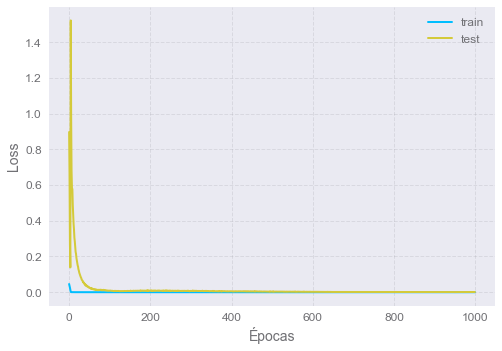

In [15]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend(fontsize=12)

In [16]:
y_train_pr = model.predict(x_train_total)
y_test_pr = model.predict(x_test_total)
y_train_pr = scaler.inverse_transform(y_train_pr.reshape(-1,1))
y_test_pr = scaler.inverse_transform(y_test_pr.reshape(-1,1))
y_test =  scaler.inverse_transform(y_train.reshape(-1,1))
y_train = scaler.inverse_transform(y_test.reshape(-1,1))
print('train mse squared:',mean_squared_error(y_train_total,y_train_pr)) 
print('test mse squared:',mean_squared_error(y_test_total,y_test_pr)) 

train mse squared: 18190.639537729658
test mse squared: 356444.0099955889


# veo como se ajustan a los train y test data para distintas localidades

In [17]:
def forecast(test_data_scaled,df1,name):
    n = len(test_data_scaled)
    lag = tw
    x_input=test_data_scaled[n-lag:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()
    lst_output=[]
    n_steps=lag
    i=0

    while(i<10): 
        if(len(temp_input)>lag):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, 1, lag))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, 1, lag))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1
    
    lst_output = scaler.inverse_transform(lst_output)
    plt.plot(lst_output,'o',label='forecast')
    plt.plot(df1,label='true data')
    plt.title(dic_localidades[str(name)])
    plt.xlabel('Días posteriores')
    plt.ylabel('Casos/100mil hab')
    plt.legend(fontsize=12)
    plt.savefig(dic_localidades[str(name)]+'_forecast_2.pdf')
    plt.show()

In [18]:
mae = tf.keras.losses.MeanAbsolutePercentageError()

RiesgoBariloche
train rmse: 3.958339284020481
test rmse: 7.463465523480547
train mape: 0.9983395049765811
test mape: 0.9903433751060648
train mape: 416244670.0
test mape: 1.315324


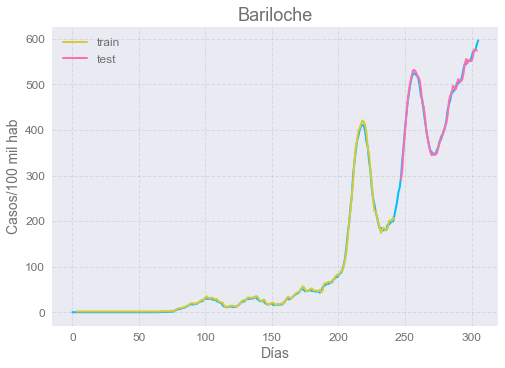

1 day output [[1.0003369]]
2 day output [[0.9978617]]
3 day output [[0.99069476]]
4 day output [[0.97925985]]
5 day output [[0.9640456]]
6 day output [[0.9457552]]
7 day output [[0.9252351]]
8 day output [[0.90348697]]
9 day output [[0.88159406]]


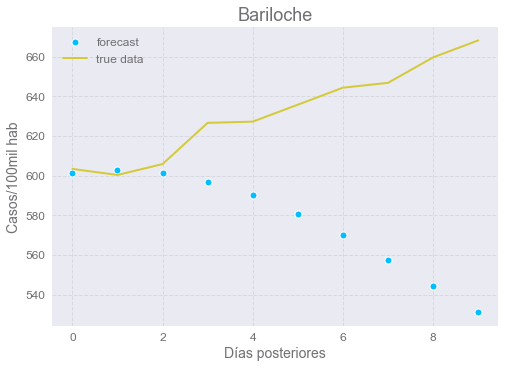

RiesgoBuenosAires
train rmse: 2.238556692156026
test rmse: 3.5766285776763804
train mape: 0.9997348180594358
test mape: 0.995800563650445
train mape: 814.2624
test mape: 0.9064768


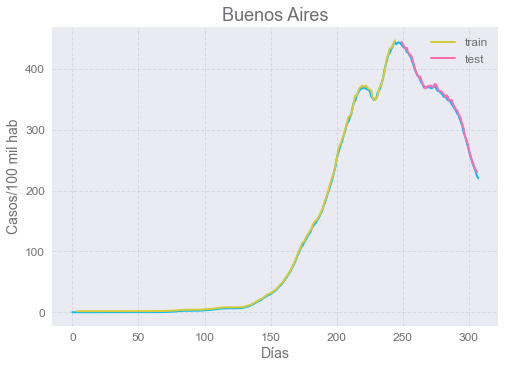

1 day output [[0.3647036]]
2 day output [[0.37036255]]
3 day output [[0.37961453]]
4 day output [[0.3918626]]
5 day output [[0.40672553]]
6 day output [[0.42380682]]
7 day output [[0.44287193]]
8 day output [[0.463797]]
9 day output [[0.48663554]]


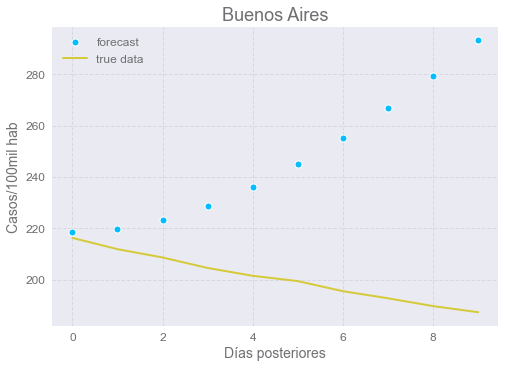

RiesgoCABACABANA
train rmse: 2.180168024088683
test rmse: 3.0784246606816246
train mape: 0.9998980307006033
test mape: 0.9988492589324173
train mape: 93312250.0
test mape: 0.8176635


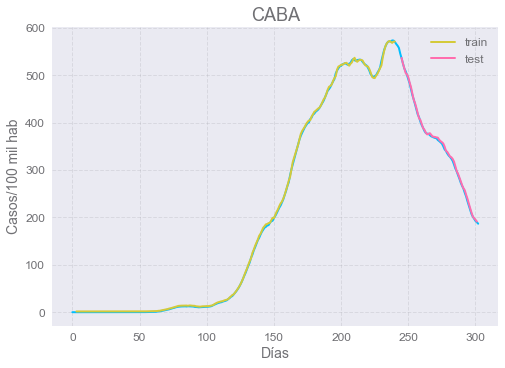

1 day output [[0.3128661]]
2 day output [[0.31935835]]
3 day output [[0.3288047]]
4 day output [[0.34191677]]
5 day output [[0.3587045]]
6 day output [[0.3782759]]
7 day output [[0.40008563]]
8 day output [[0.42367968]]
9 day output [[0.44886497]]


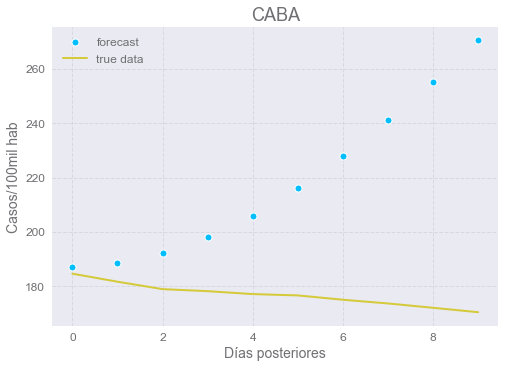

RiesgoChacoNA
train rmse: 2.1540839318013068
test rmse: 4.097129417109079
train mape: 0.9952221618834683
test mape: 0.9876232608457369
train mape: 18.812223
test mape: 1.9456064


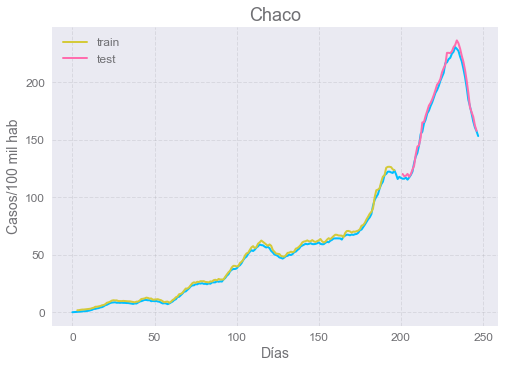

1 day output [[0.25364828]]
2 day output [[0.25765932]]
3 day output [[0.26399064]]
4 day output [[0.27309936]]
5 day output [[0.2845969]]
6 day output [[0.29865423]]
7 day output [[0.31530353]]
8 day output [[0.33486727]]
9 day output [[0.357812]]


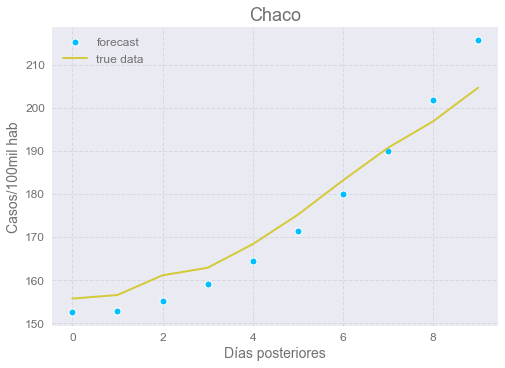

RiesgoCórdobaCórdoba
train rmse: 1.594259031589877
test rmse: 4.953368004873006
train mape: 0.9967549417281447
test mape: 0.9991380408603927
train mape: 65424856.0
test mape: 0.8452058


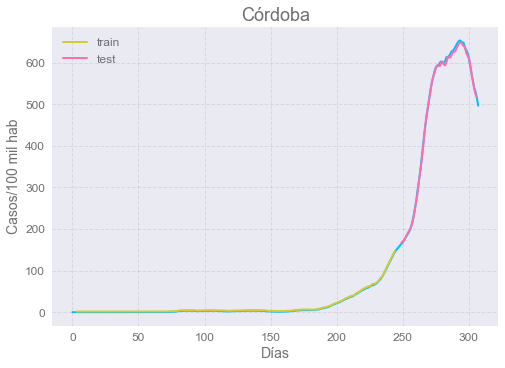

1 day output [[0.7740847]]
2 day output [[0.75280875]]
3 day output [[0.733681]]
4 day output [[0.7174094]]
5 day output [[0.70348155]]
6 day output [[0.6920831]]
7 day output [[0.6830191]]
8 day output [[0.6762929]]
9 day output [[0.6717804]]


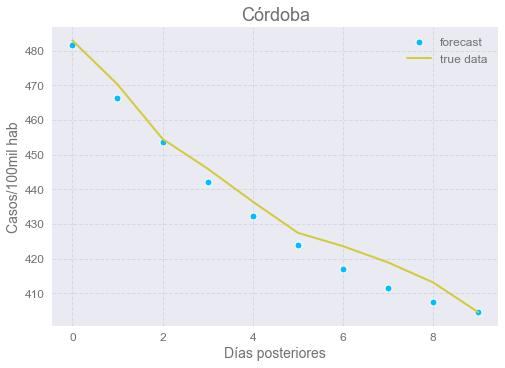

RiesgoEntreRiosRíos
train rmse: 1.8941548228586687
test rmse: 3.817117126481087
train mape: 0.9977115628913871
test mape: 0.9978503395207624
train mape: 28369054.0
test mape: 1.5127832


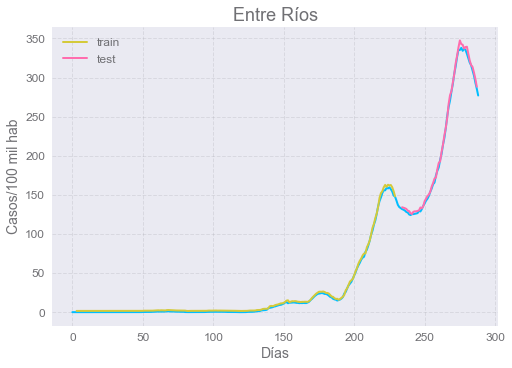

1 day output [[0.44231942]]
2 day output [[0.4378247]]
3 day output [[0.43580216]]
4 day output [[0.4367029]]
5 day output [[0.44014648]]
6 day output [[0.4461599]]
7 day output [[0.4545404]]
8 day output [[0.46523353]]
9 day output [[0.4781669]]


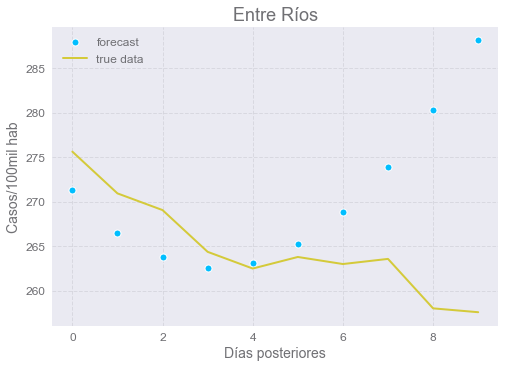

RiesgoJujuyJujuy
train rmse: 2.7188952789101943
test rmse: 3.9726853968337683
train mape: 0.9997309494272304
test mape: 0.9986507739079837
train mape: 62967264.0
test mape: 2.3031313


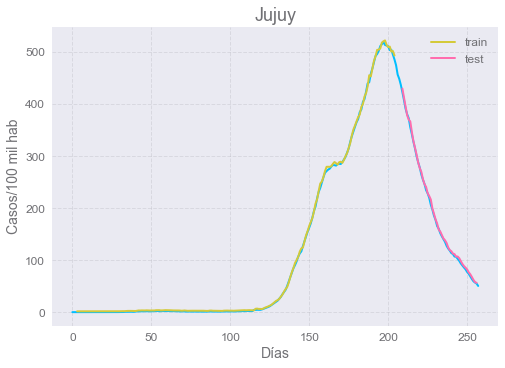

1 day output [[0.08305036]]
2 day output [[0.08625048]]
3 day output [[0.09088488]]
4 day output [[0.09762345]]
5 day output [[0.10592455]]
6 day output [[0.11597842]]
7 day output [[0.12770371]]
8 day output [[0.14127457]]
9 day output [[0.1568625]]


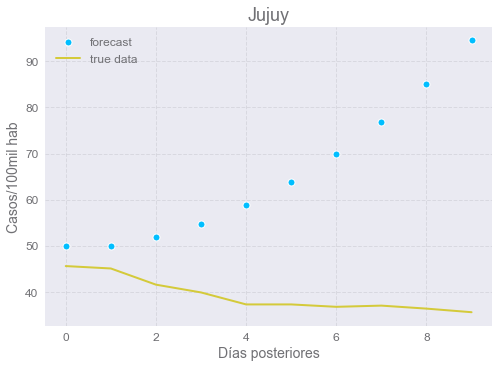

RiesgoLaRiojaRioja
train rmse: 2.283466048533892
test rmse: 6.992007179985213
train mape: 0.9990229169663651
test mape: 0.9892294210097696
train mape: 83375420.0
test mape: 1.6308862


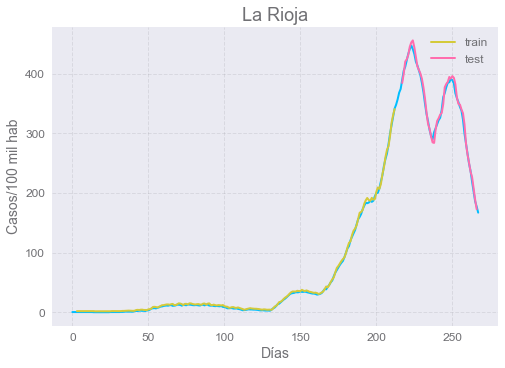

1 day output [[0.25847852]]
2 day output [[0.2542431]]
3 day output [[0.25267664]]
4 day output [[0.25436908]]
5 day output [[0.25874963]]
6 day output [[0.2658729]]
7 day output [[0.27550536]]
8 day output [[0.28764674]]
9 day output [[0.3022949]]


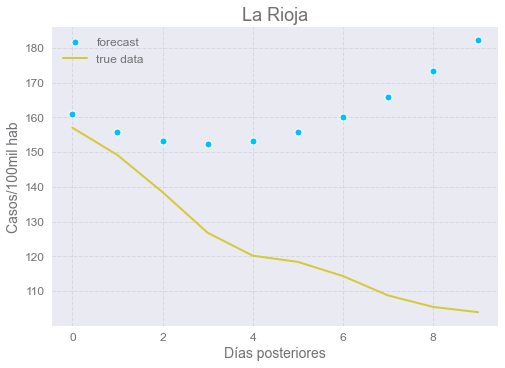

RiesgoMendozaMendoza
train rmse: 1.7203478244323571
test rmse: 4.043136625715444
train mape: 0.9996891886986234
test mape: 0.9904662717716913
train mape: 60470116.0
test mape: 0.74711007


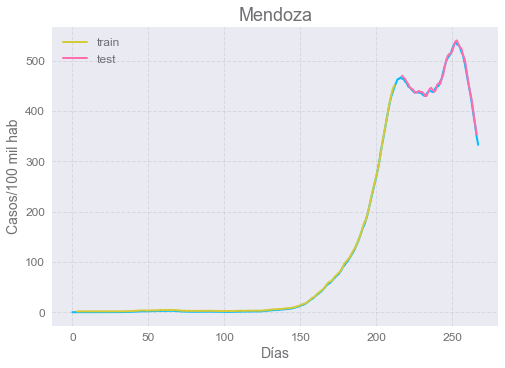

1 day output [[0.49847153]]
2 day output [[0.4746814]]
3 day output [[0.4540161]]
4 day output [[0.43585238]]
5 day output [[0.4210316]]
6 day output [[0.40952554]]
7 day output [[0.40164194]]
8 day output [[0.39733505]]
9 day output [[0.3965695]]


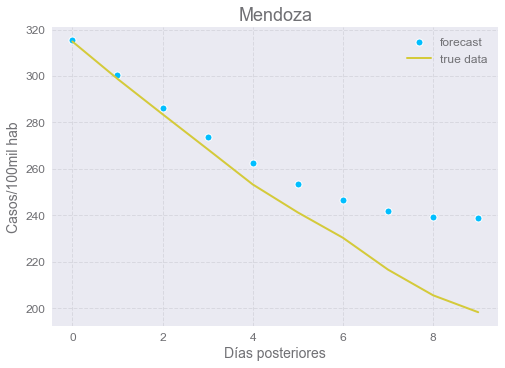

RiesgoNeuquénNeuquén
train rmse: 2.1322424212802757
test rmse: 22.87050421750956
train mape: 0.9995267848446983
test mape: 0.9652456707852771
train mape: 65.39162
test mape: 2.408065


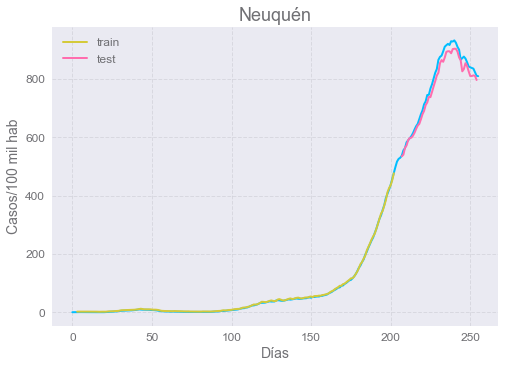

1 day output [[1.2555581]]
2 day output [[1.1933151]]
3 day output [[1.1244167]]
4 day output [[1.0447644]]
5 day output [[0.9607829]]
6 day output [[0.8732891]]
7 day output [[0.7845834]]
8 day output [[0.69551134]]
9 day output [[0.60075957]]


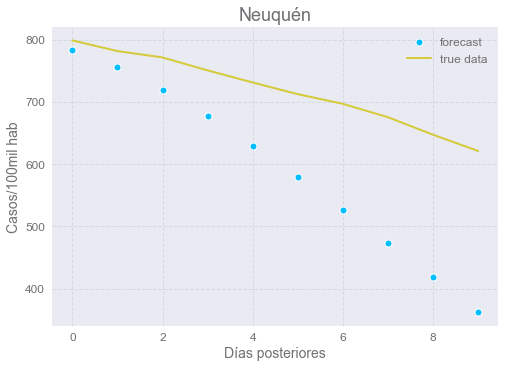

RiesgoRioNegro
train rmse: 2.3624862929133075
test rmse: 9.728942760551508
train mape: 0.9991872153380335
test mape: 0.9934413165830026
train mape: 198357100.0
test mape: 1.2274922


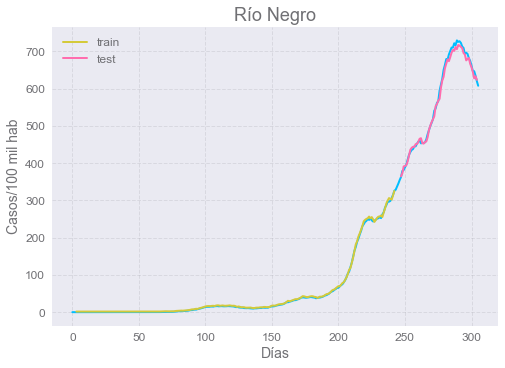

1 day output [[0.9490971]]
2 day output [[0.9160418]]
3 day output [[0.8837251]]
4 day output [[0.8518372]]
5 day output [[0.8216794]]
6 day output [[0.79305506]]
7 day output [[0.7667683]]
8 day output [[0.74315596]]
9 day output [[0.7222064]]


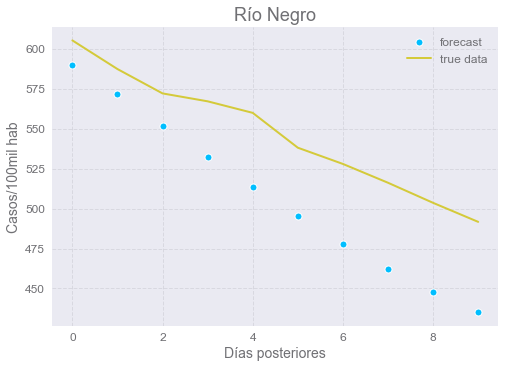

RiesgoSaltaSalta
train rmse: 1.812560813736102
test rmse: 4.686251876311622
train mape: 0.999375810746677
test mape: 0.9955714425916256
train mape: 54732256.0
test mape: 1.8312494


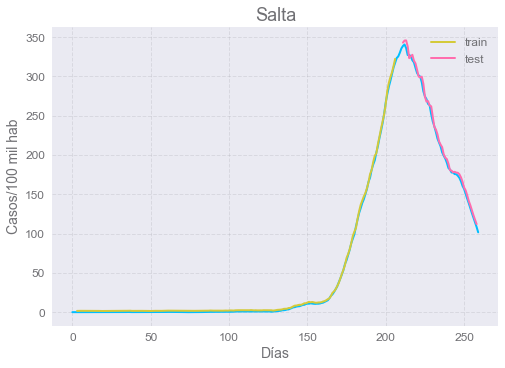

1 day output [[0.16201489]]
2 day output [[0.16391824]]
3 day output [[0.16848478]]
4 day output [[0.17605218]]
5 day output [[0.18604672]]
6 day output [[0.19845936]]
7 day output [[0.21310292]]
8 day output [[0.22970977]]
9 day output [[0.24804282]]


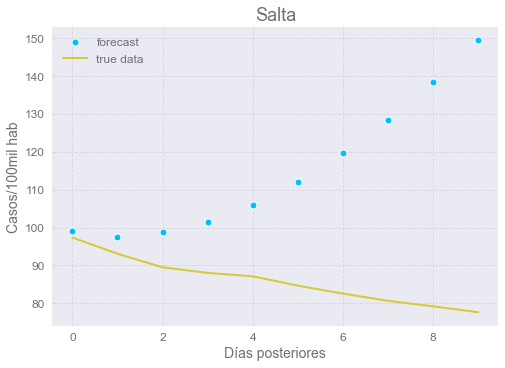

RiesgoSantaCruzSantaCruz
train rmse: 3.476099526021921
test rmse: 8.147010683850052
train mape: 0.9987728746350091
test mape: 0.9935559470138289
train mape: 65419460.0
test mape: 1.1256852


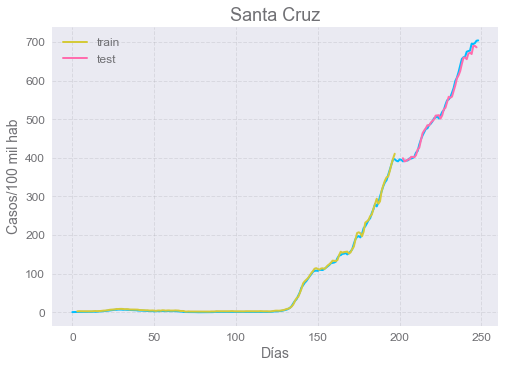

1 day output [[1.1306405]]
2 day output [[1.0990874]]
3 day output [[1.061469]]
4 day output [[1.0175793]]
5 day output [[0.9696803]]
6 day output [[0.91971886]]
7 day output [[0.8696202]]
8 day output [[0.8201701]]
9 day output [[0.7722315]]


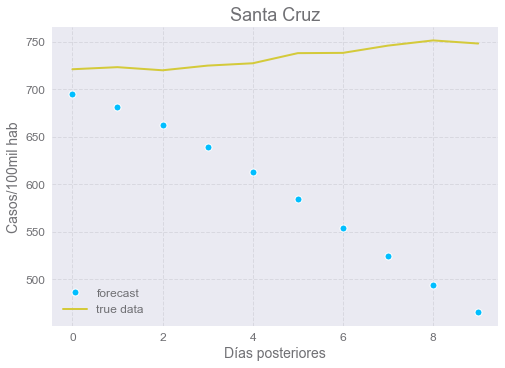

RiesgoSantaFeSantaFe
train rmse: 1.6310485240417207
test rmse: 17.376198341487886
train mape: 0.9996206667756468
test mape: 0.9784239207277794
train mape: 15716684.0
test mape: 1.9716119


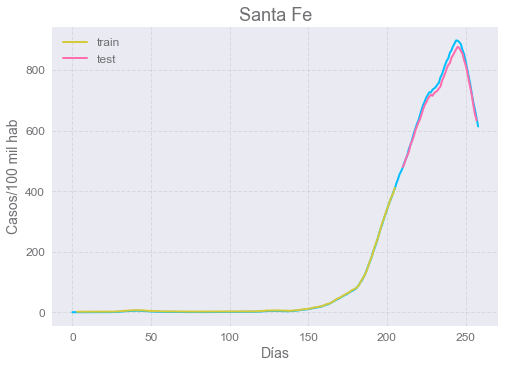

1 day output [[0.9141908]]
2 day output [[0.8610273]]
3 day output [[0.80903757]]
4 day output [[0.7585425]]
5 day output [[0.71084976]]
6 day output [[0.6659423]]
7 day output [[0.623486]]
8 day output [[0.58243775]]
9 day output [[0.5426945]]


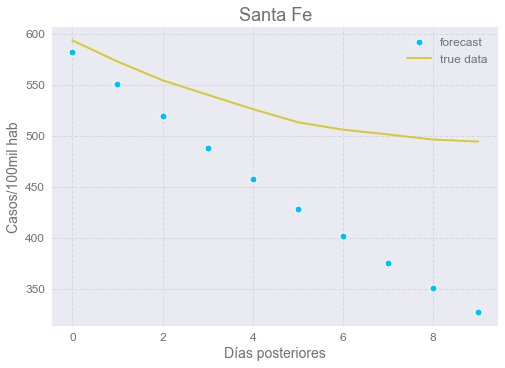

RiesgoTierradelFuegoTierradel
train rmse: 3.744345185760178
test rmse: 68.8561655134053
train mape: 0.999511317108664
test mape: 0.9876846907625135
train mape: 73145310.0
test mape: 3.8732648


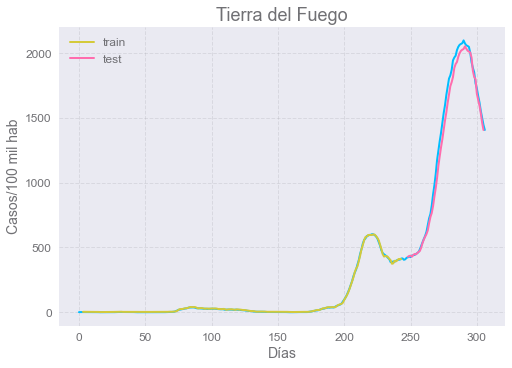

1 day output [[2.0391157]]
2 day output [[1.8359841]]
3 day output [[1.5975369]]
4 day output [[1.3031367]]
5 day output [[0.95509523]]
6 day output [[0.5064658]]
7 day output [[-0.04287269]]
8 day output [[-0.2195211]]
9 day output [[-0.1380796]]


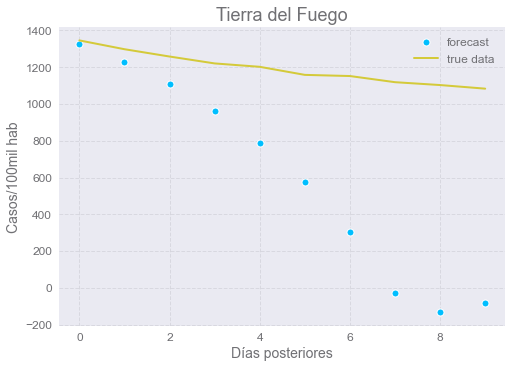

RiesgoTucumanTucuman
train rmse: 1.6230035255860702
test rmse: 20.576532365772653
train mape: 0.9996478340986376
test mape: 0.9869189059268836
train mape: 157.12448
test mape: 2.2134016


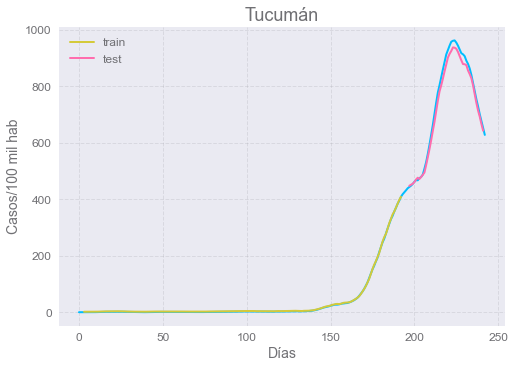

1 day output [[0.9444275]]
2 day output [[0.8930798]]
3 day output [[0.84335876]]
4 day output [[0.79388016]]
5 day output [[0.74710435]]
6 day output [[0.7026563]]
7 day output [[0.6614403]]
8 day output [[0.622928]]
9 day output [[0.586322]]


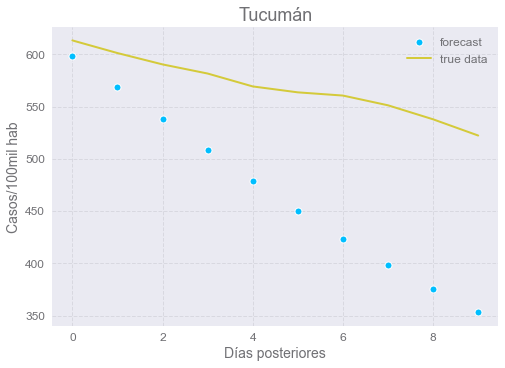

In [19]:
for file in files:
    print(file)
    data = pd.read_csv(mypath+str('/')+file,sep=",",quotechar='"',na_values=[''])
    data = data["incidenciaAcum14d"]
    df = pd.DataFrame(data)
    df = df.to_numpy()
    df_forecast = df[-20:-10]
    df = df[:-20]
    df_original = np.copy(df)
    total_size = df.shape[0]
    train_size = int(0.8*total_size)
    test_size = total_size - train_size
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    train_data = scaler.transform(train_data.reshape(-1,1))
    test_data = scaler.transform(test_data.reshape(-1,1))
    #train
    x_train, y_train = create_dataset(train_data,tw)
    #test
    x_test, y_test = create_dataset(test_data,tw)
    x_train = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
    x_test= x_test.reshape(x_test.shape[0],1,x_test.shape[1])
    y_train_pr = model.predict(x_train)
    y_test_pr = model.predict(x_test)
    y_train_pr = scaler.inverse_transform(y_train_pr.reshape(-1,1))
    y_test_pr = scaler.inverse_transform(y_test_pr.reshape(-1,1))
    y_train = scaler.inverse_transform(y_train.reshape(-1,1))
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))
    #imprimo mse para train y test
    print('train rmse:',np.sqrt(mean_squared_error(y_train,y_train_pr))) 
    print('test rmse:',np.sqrt(mean_squared_error(y_test,y_test_pr)))
    #imprimo r2
    print('train mape:',r2_score(y_train,y_train_pr)) 
    print('test mape:',r2_score(y_test,y_test_pr)) 
    #imprimo mae
    print('train mape:',mae(y_train,y_train_pr).numpy()) 
    print('test mape:',mae(y_test,y_test_pr).numpy()) 
    graph_predictions(tw,df_original,y_train_pr,y_test_pr,file)
    forecast(test_data,df_forecast,file)